Bleached Corals - Total Images: 484
Healthy Corals - Total Images: 438


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5980 - loss: 0.9842 - val_accuracy: 0.6865 - val_loss: 0.6092 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/step - accuracy: 0.6963 - loss: 0.5893 - val_accuracy: 0.6865 - val_loss: 0.5726 - learning_rate: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 431ms/step - accuracy: 0.7335 - loss: 0.5231 - val_accuracy: 0.7081 - val_loss: 0.5627 - learning_rate: 0.0010
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 426ms/step - accuracy: 0.7149 - loss: 0.5617 - val_accuracy: 0.6973 - val_loss: 0.5632 - learning_rate: 0.0010
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 424ms/step - accuracy: 0.7048 - loss: 0.5966 - val_accuracy: 0.6703 - val_loss: 0.5749 - learning_rate: 0.0010
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 423ms/step - accuracy: 0.7665 - loss: 0.4935 - val_accuracy: 0.6703 - val_loss: 0.6052 - learning_rate: 0.0010
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - accuracy: 0.6811 - loss: 0.599

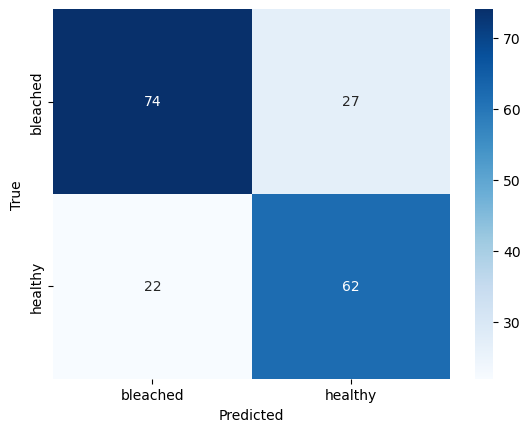

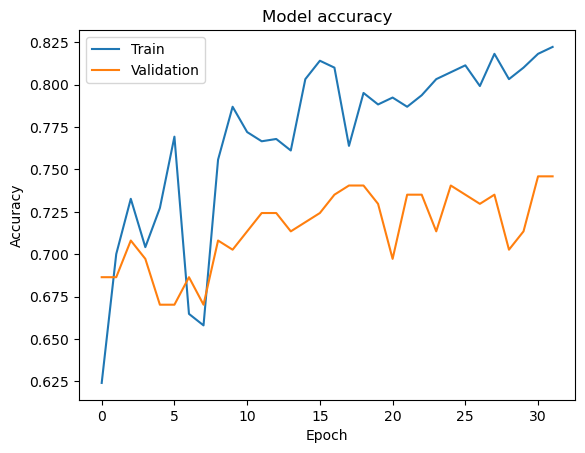

In [3]:
# Install dependencies
!pip install numpy pillow scikit-learn seaborn tensorflow

# Imports
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Dataset Overview
bleached_path = "UW-Madison-GI-Tract-Image-Segmentation/data/bleached_corals"
healthy_path = "UW-Madison-GI-Tract-Image-Segmentation/data/healthy_corals"

def get_image_paths(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Get all image paths
bleached_image_paths = get_image_paths(bleached_path)
print(f"Bleached Corals - Total Images: {len(bleached_image_paths)}")
healthy_image_paths = get_image_paths(healthy_path)
print(f"Healthy Corals - Total Images: {len(healthy_image_paths)}")

# Prepare dataset
image_paths = bleached_image_paths + healthy_image_paths
labels = ['bleached'] * len(bleached_image_paths) + ['healthy'] * len(healthy_image_paths)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42)

# Image Data Generator with Augmentation
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((299, 299))
    img = np.array(img)
    if img.shape[2] == 4:  # Remove alpha channel if present
        img = img[:, :, :3]
    return img

train_images = np.array([preprocess_image(path) for path in train_paths])
test_images = np.array([preprocess_image(path) for path in test_paths])

train_images = train_images / 255.0
test_images = test_images / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load GoogleNet (InceptionV3) model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=50,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Make predictions
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int)

# Classification report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Bleached Corals - Total Images: 484
Healthy Corals - Total Images: 438


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6124 - loss: 1.1812 - val_accuracy: 0.6378 - val_loss: 0.6423 - learning_rate: 0.0010
Epoch 2/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - accuracy: 0.6533 - loss: 0.6163 - val_accuracy: 0.6703 - val_loss: 0.6101 - learning_rate: 0.0010
Epoch 3/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 424ms/step - accuracy: 0.7069 - loss: 0.5651 - val_accuracy: 0.6108 - val_loss: 0.7353 - learning_rate: 0.0010
Epoch 4/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 424ms/step - accuracy: 0.6961 - loss: 0.5733 - val_accuracy: 0.6703 - val_loss: 0.6160 - learning_rate: 0.0010
Epoch 5/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 429ms/step - accuracy: 0.7610 - loss: 0.4945 - val_accuracy: 0.7459 - val_loss: 0.5336 - learning_rate: 0.0010
Epoch 6/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.7428 - loss: 0.5116 - val_accuracy: 0.6649 - val_loss: 0.6306 - learning_rate: 0.0010
Epoch 7/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 433ms/step - accuracy: 0.7147 - loss: 0.570

2024-11-30 14:36:12.783674: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11237', 76 bytes spill stores, 76 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7092 - loss: 0.5513 - val_accuracy: 0.7676 - val_loss: 0.5086 - learning_rate: 1.0000e-05
Epoch 2/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.7916 - loss: 0.4434 - val_accuracy: 0.7459 - val_loss: 0.5137 - learning_rate: 1.0000e-05
Epoch 3/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - accuracy: 0.7964 - loss: 0.4313 - val_accuracy: 0.7351 - val_loss: 0.5164 - learning_rate: 1.0000e-05
Epoch 4/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - accuracy: 0.8124 - loss: 0.4026 - val_accuracy: 0.7622 - val_loss: 0.5009 - learning_rate: 1.0000e-05
Epoch 5/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - accuracy: 0.8361 - loss: 0.3856 - val_accuracy: 0.7784 - val_loss: 0.4844 - learning_rate: 1.0000e-05
Epoch 6/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 433ms/step - accuracy: 0.8493 - loss: 0.3680 - val_accuracy: 0.7622 - val_loss: 0.4829 - learning_rate: 1.0000e-05
Epoch 7/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - accuracy: 0.8073 

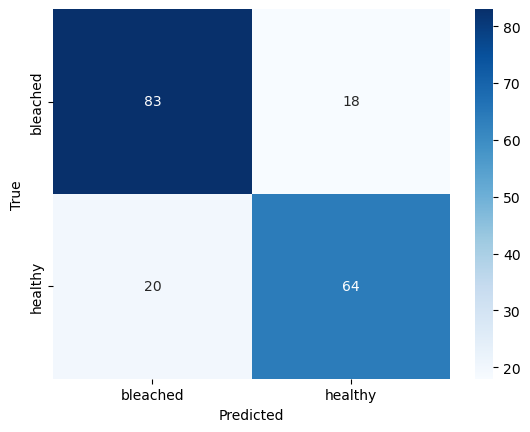

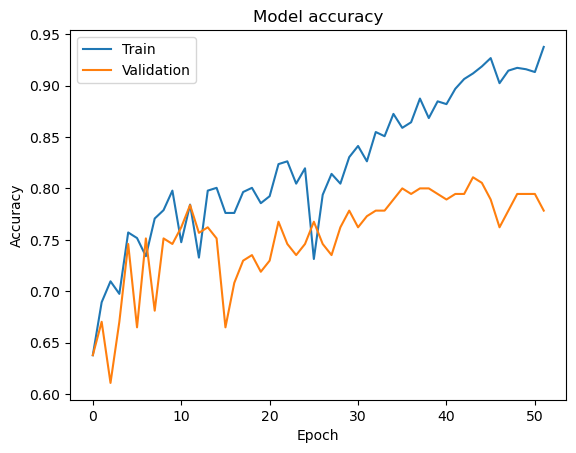

In [4]:
# Install dependencies
!pip install numpy pillow scikit-learn seaborn tensorflow

# Imports
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Dataset Overview
bleached_path = "UW-Madison-GI-Tract-Image-Segmentation/data/bleached_corals"
healthy_path = "UW-Madison-GI-Tract-Image-Segmentation/data/healthy_corals"

def get_image_paths(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Get all image paths
bleached_image_paths = get_image_paths(bleached_path)
print(f"Bleached Corals - Total Images: {len(bleached_image_paths)}")
healthy_image_paths = get_image_paths(healthy_path)
print(f"Healthy Corals - Total Images: {len(healthy_image_paths)}")

# Prepare dataset
image_paths = bleached_image_paths + healthy_image_paths
labels = ['bleached'] * len(bleached_image_paths) + ['healthy'] * len(healthy_image_paths)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42)

# Image Data Generator with Augmentation
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((299, 299))
    img = np.array(img)
    if img.shape[2] == 4:  # Remove alpha channel if present
        img = img[:, :, :3]
    return img

train_images = np.array([preprocess_image(path) for path in train_paths])
test_images = np.array([preprocess_image(path) for path in test_paths])

train_images = train_images / 255.0
test_images = test_images / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load GoogleNet (InceptionV3) model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=80,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=80,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Make predictions
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int)

# Classification report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Bleached Corals - Total Images: 484
Healthy Corals - Total Images: 438


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5211 - loss: 1.5437 - val_accuracy: 0.6973 - val_loss: 0.5999 - learning_rate: 0.0010
Epoch 2/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - accuracy: 0.7056 - loss: 0.5739 - val_accuracy: 0.6378 - val_loss: 0.6147 - learning_rate: 0.0010
Epoch 3/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 446ms/step - accuracy: 0.7598 - loss: 0.4926 - val_accuracy: 0.6919 - val_loss: 0.5678 - learning_rate: 0.0010
Epoch 4/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 448ms/step - accuracy: 0.7139 - loss: 0.5499 - val_accuracy: 0.7027 - val_loss: 0.5723 - learning_rate: 0.0010
Epoch 5/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - accuracy: 0.7008 - loss: 0.5314 - val_accuracy: 0.7027 - val_loss: 0.5434 - learning_rate: 0.0010
Epoch 6/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - accuracy: 0.6875 - loss: 0.5940 - val_accuracy: 0.7135 - val_loss: 0.5464 - learning_rate: 0.0010
Epoch 7/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 444ms/step - accuracy: 0.7460 - loss: 0.478

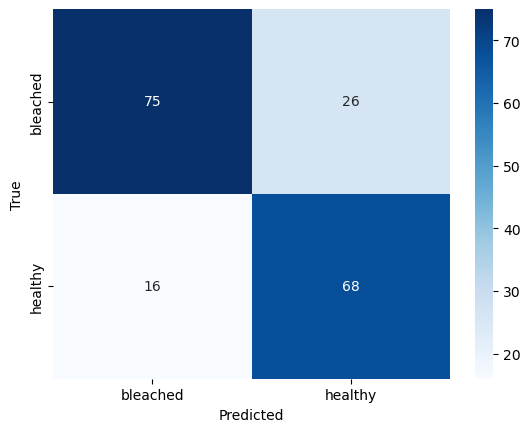

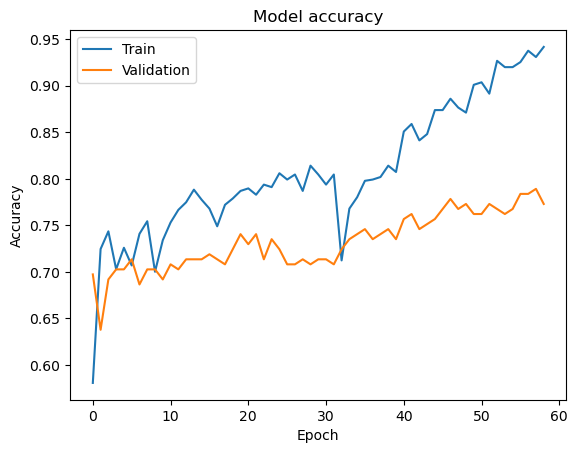

In [5]:
# Install dependencies
!pip install numpy pillow scikit-learn seaborn tensorflow

# Imports
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Dataset Overview
bleached_path = "UW-Madison-GI-Tract-Image-Segmentation/data/bleached_corals"
healthy_path = "UW-Madison-GI-Tract-Image-Segmentation/data/healthy_corals"

def get_image_paths(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Get all image paths
bleached_image_paths = get_image_paths(bleached_path)
print(f"Bleached Corals - Total Images: {len(bleached_image_paths)}")
healthy_image_paths = get_image_paths(healthy_path)
print(f"Healthy Corals - Total Images: {len(healthy_image_paths)}")

# Prepare dataset
image_paths = bleached_image_paths + healthy_image_paths
labels = ['bleached'] * len(bleached_image_paths) + ['healthy'] * len(healthy_image_paths)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42)

# Image Data Generator with Augmentation
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((299, 299))
    img = np.array(img)
    if img.shape[2] == 4:  # Remove alpha channel if present
        img = img[:, :, :3]
    return img

train_images = np.array([preprocess_image(path) for path in train_paths])
test_images = np.array([preprocess_image(path) for path in test_paths])

train_images = train_images / 255.0
test_images = test_images / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load GoogleNet (InceptionV3) model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=80,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze more layers of the base model for fine-tuning
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=80,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Make predictions
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int)

# Classification report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Bleached Corals - Total Images: 484
Healthy Corals - Total Images: 438


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
 1/24 ━━━━━━━━━━━━━━━━━━━━ 4:31 12s/step - accuracy: 0.4688 - loss: 0.8066

2024-11-30 15:01:36.230544: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_concatenate_multiply_fusion_1', 16 bytes spill stores, 16 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.5282 - loss: 1.2065

2024-11-30 15:01:57.517009: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_concatenate_multiply_fusion_1', 16 bytes spill stores, 16 bytes spill loads

2024-11-30 15:02:02.941634: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_concatenate_multiply_fusion', 8 bytes spill stores, 8 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5292 - loss: 1.1997 - val_accuracy: 0.5243 - val_loss: 0.9577 - learning_rate: 0.0010
Epoch 2/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - accuracy: 0.7209 - loss: 0.5732 - val_accuracy: 0.6865 - val_loss: 0.5840 - learning_rate: 0.0010
Epoch 3/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - accuracy: 0.6903 - loss: 0.5754 - val_accuracy: 0.7189 - val_loss: 0.5521 - learning_rate: 0.0010
Epoch 4/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - accuracy: 0.7342 - loss: 0.5204 - val_accuracy: 0.6757 - val_loss: 0.5790 - learning_rate: 0.0010
Epoch 5/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - accuracy: 0.7295 - loss: 0.5148 - val_accuracy: 0.7189 - val_loss: 0.5481 - learning_rate: 0.0010
Epoch 6/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - accuracy: 0.7541 - loss: 0.5337 - val_accuracy: 0.6865 - val_loss: 0.5565 - learning_rate: 0.0010
Epoch 7/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 450ms/step - accuracy: 0.7376 - loss: 0.4951 - val_acc

2024-11-30 15:10:13.606270: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_concatenate_multiply_fusion_1', 16 bytes spill stores, 16 bytes spill loads



6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step 


2024-11-30 15:10:20.544599: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_concatenate_multiply_fusion', 8 bytes spill stores, 8 bytes spill loads



              precision    recall  f1-score   support

    bleached       0.83      0.75      0.79       101
     healthy       0.73      0.81      0.77        84

    accuracy                           0.78       185
   macro avg       0.78      0.78      0.78       185
weighted avg       0.78      0.78      0.78       185



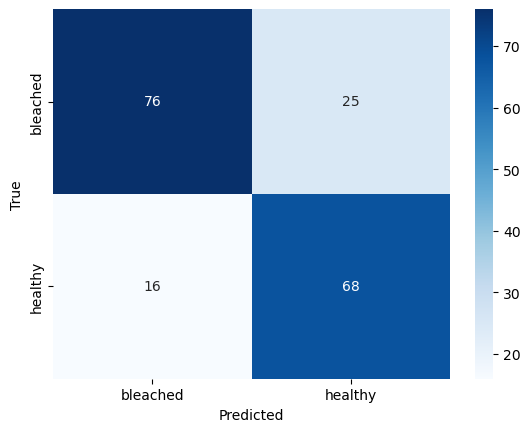

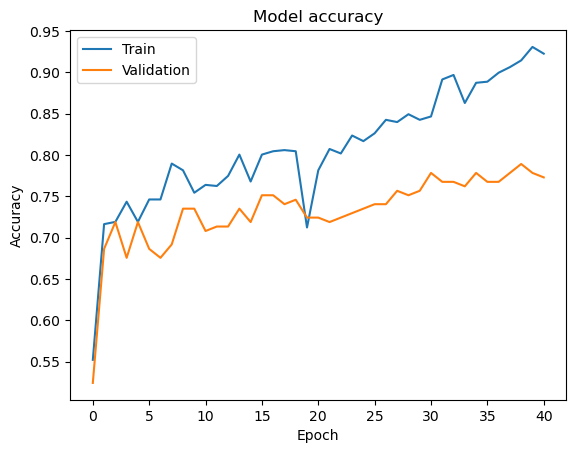

In [6]:
# Install dependencies
!pip install numpy pillow scikit-learn seaborn tensorflow

# Imports
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Dataset Overview
bleached_path = "UW-Madison-GI-Tract-Image-Segmentation/data/bleached_corals"
healthy_path = "UW-Madison-GI-Tract-Image-Segmentation/data/healthy_corals"

def get_image_paths(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Get all image paths
bleached_image_paths = get_image_paths(bleached_path)
print(f"Bleached Corals - Total Images: {len(bleached_image_paths)}")
healthy_image_paths = get_image_paths(healthy_path)
print(f"Healthy Corals - Total Images: {len(healthy_image_paths)}")

# Prepare dataset
image_paths = bleached_image_paths + healthy_image_paths
labels = ['bleached'] * len(bleached_image_paths) + ['healthy'] * len(healthy_image_paths)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42)

# Image Data Generator with Augmentation
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((299, 299))
    img = np.array(img)
    if img.shape[2] == 4:  # Remove alpha channel if present
        img = img[:, :, :3]
    return img

train_images = np.array([preprocess_image(path) for path in train_paths])
test_images = np.array([preprocess_image(path) for path in test_paths])

train_images = train_images / 255.0
test_images = test_images / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load GoogleNet (InceptionV3) model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='sigmoid')(x)  # Change activation to sigmoid
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=80,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze more layers of the base model for fine-tuning
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=80,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Make predictions
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int)

# Classification report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Bleached Corals - Total Images: 484
Healthy Corals - Total Images: 438


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4958 - loss: 1.7800 - val_accuracy: 0.5946 - val_loss: 0.6755 - learning_rate: 0.0010
Epoch 2/70
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - accuracy: 0.6860 - loss: 0.5975 - val_accuracy: 0.6486 - val_loss: 0.5975 - learning_rate: 0.0010
Epoch 3/70
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 436ms/step - accuracy: 0.7065 - loss: 0.5417 - val_accuracy: 0.7243 - val_loss: 0.5606 - learning_rate: 0.0010
Epoch 4/70
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step - accuracy: 0.7348 - loss: 0.5193 - val_accuracy: 0.6757 - val_loss: 0.5974 - learning_rate: 0.0010
Epoch 5/70
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 448ms/step - accuracy: 0.7064 - loss: 0.5380 - val_accuracy: 0.7081 - val_loss: 0.5587 - learning_rate: 0.0010
Epoch 6/70
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 446ms/step - accuracy: 0.7269 - loss: 0.5258 - val_accuracy: 0.7081 - val_loss: 0.5454 - learning_rate: 0.0010
Epoch 7/70
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - accuracy: 0.7079 - loss: 0.540

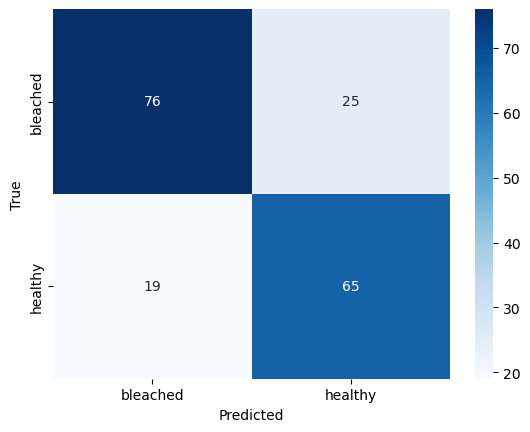

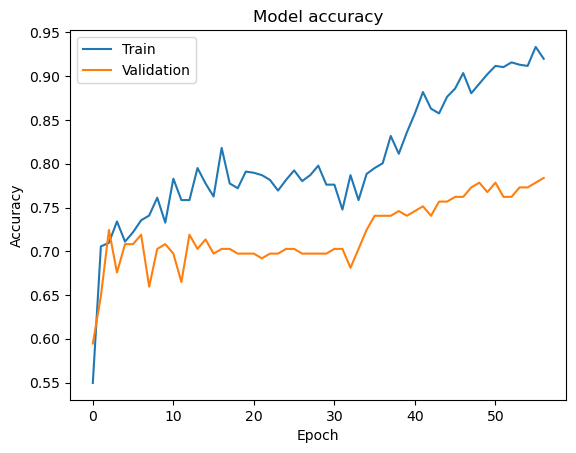

In [7]:
# Install dependencies
!pip install numpy pillow scikit-learn seaborn tensorflow

# Imports
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Dataset Overview
bleached_path = "UW-Madison-GI-Tract-Image-Segmentation/data/bleached_corals"
healthy_path = "UW-Madison-GI-Tract-Image-Segmentation/data/healthy_corals"

def get_image_paths(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Get all image paths
bleached_image_paths = get_image_paths(bleached_path)
print(f"Bleached Corals - Total Images: {len(bleached_image_paths)}")
healthy_image_paths = get_image_paths(healthy_path)
print(f"Healthy Corals - Total Images: {len(healthy_image_paths)}")

# Prepare dataset
image_paths = bleached_image_paths + healthy_image_paths
labels = ['bleached'] * len(bleached_image_paths) + ['healthy'] * len(healthy_image_paths)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42)

# Image Data Generator with Augmentation
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((299, 299))
    img = np.array(img)
    if img.shape[2] == 4:  # Remove alpha channel if present
        img = img[:, :, :3]
    return img

train_images = np.array([preprocess_image(path) for path in train_paths])
test_images = np.array([preprocess_image(path) for path in test_paths])

train_images = train_images / 255.0
test_images = test_images / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load GoogleNet (InceptionV3) model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=70,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze more layers of the base model for fine-tuning
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=70,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Make predictions
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int)

# Classification report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Bleached Corals - Total Images: 484
Healthy Corals - Total Images: 438


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5383 - loss: 1.2636 - val_accuracy: 0.5784 - val_loss: 0.6996 - learning_rate: 0.0010
Epoch 2/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/step - accuracy: 0.5944 - loss: 0.7119 - val_accuracy: 0.6595 - val_loss: 0.6034 - learning_rate: 0.0010
Epoch 3/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 434ms/step - accuracy: 0.7438 - loss: 0.5136 - val_accuracy: 0.6595 - val_loss: 0.5568 - learning_rate: 0.0010
Epoch 4/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 433ms/step - accuracy: 0.7105 - loss: 0.5645 - val_accuracy: 0.7135 - val_loss: 0.5393 - learning_rate: 0.0010
Epoch 5/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 428ms/step - accuracy: 0.7489 - loss: 0.5033 - val_accuracy: 0.6973 - val_loss: 0.5685 - learning_rate: 0.0010
Epoch 6/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - accuracy: 0.7664 - loss: 0.4955 - val_accuracy: 0.7027 - val_loss: 0.5673 - learning_rate: 0.0010
Epoch 7/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 435ms/step - accuracy: 0.7847 - loss: 0.466

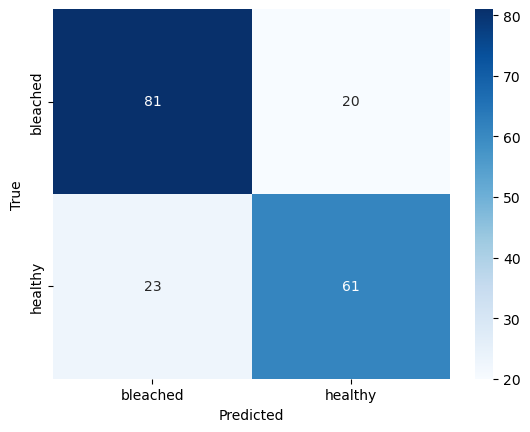

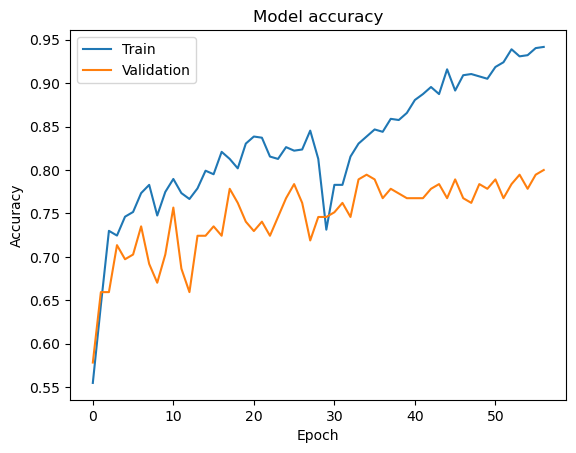

In [9]:
# Install dependencies
!pip install numpy pillow scikit-learn seaborn tensorflow

# Imports
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Dataset Overview
bleached_path = "UW-Madison-GI-Tract-Image-Segmentation/data/bleached_corals"
healthy_path = "UW-Madison-GI-Tract-Image-Segmentation/data/healthy_corals"

def get_image_paths(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Get all image paths
bleached_image_paths = get_image_paths(bleached_path)
print(f"Bleached Corals - Total Images: {len(bleached_image_paths)}")
healthy_image_paths = get_image_paths(healthy_path)
print(f"Healthy Corals - Total Images: {len(healthy_image_paths)}")

# Prepare dataset
image_paths = bleached_image_paths + healthy_image_paths
labels = ['bleached'] * len(bleached_image_paths) + ['healthy'] * len(healthy_image_paths)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42)

# Image Data Generator with Augmentation
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((299, 299))
    img = np.array(img)
    if img.shape[2] == 4:  # Remove alpha channel if present
        img = img[:, :, :3]
    return img

train_images = np.array([preprocess_image(path) for path in train_paths])
test_images = np.array([preprocess_image(path) for path in test_paths])

train_images = train_images / 255.0
test_images = test_images / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load GoogleNet (InceptionV3) model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=80,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=80,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Make predictions
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int)

# Classification report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Bleached Corals - Total Images: 484
Healthy Corals - Total Images: 438


2024-12-04 09:05:26.343740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13294 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:e6:00.0, compute capability: 8.6
/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80


I0000 00:00:1733303135.334491    1731 service.cc:146] XLA service 0x7f1d28002170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733303135.334542    1731 service.cc:154]   StreamExecutor device (0): NVIDIA A16, Compute Capability 8.6
2024-12-04 09:05:35.526540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 09:05:36.799680: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-04 09:05:37.100493: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
20

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5560 - loss: 1.2535

2024-12-04 09:06:43.889280: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_concatenate_multiply_fusion_1', 16 bytes spill stores, 16 bytes spill loads

2024-12-04 09:06:45.642938: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2424', 4 bytes spill stores, 4 bytes spill loads

2024-12-04 09:06:46.628518: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2424', 28 bytes spill stores, 28 bytes spill loads

2024-12-04 09:06:46.702844: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2424', 176 bytes spill stores, 176 bytes spill loads

2024-12-04 09:06:46.860726: I external/local_x

24/24 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.5578 - loss: 1.2438 - val_accuracy: 0.4919 - val_loss: 0.9260 - learning_rate: 0.0010
Epoch 2/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - accuracy: 0.5992 - loss: 0.7117 - val_accuracy: 0.5946 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 3/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 448ms/step - accuracy: 0.6683 - loss: 0.6003 - val_accuracy: 0.6378 - val_loss: 0.6248 - learning_rate: 0.0010
Epoch 4/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - accuracy: 0.7030 - loss: 0.5524 - val_accuracy: 0.6216 - val_loss: 0.7456 - learning_rate: 0.0010
Epoch 5/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - accuracy: 0.7178 - loss: 0.6104 - val_accuracy: 0.6541 - val_loss: 0.6126 - learning_rate: 0.0010
Epoch 6/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - accuracy: 0.6992 - loss: 0.5401 - val_accuracy: 0.6919 - val_loss: 0.5764 - learning_rate: 0.0010
Epoch 7/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - accuracy: 0.7581 - loss: 0.4723 - val_acc

2024-12-04 09:19:59.193663: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11237', 76 bytes spill stores, 76 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7549 - loss: 0.4961 - val_accuracy: 0.7297 - val_loss: 0.5386 - learning_rate: 1.0000e-05
Epoch 2/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - accuracy: 0.7958 - loss: 0.4276 - val_accuracy: 0.7405 - val_loss: 0.5532 - learning_rate: 1.0000e-05
Epoch 3/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - accuracy: 0.8198 - loss: 0.4219 - val_accuracy: 0.7514 - val_loss: 0.5397 - learning_rate: 1.0000e-05
Epoch 4/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 446ms/step - accuracy: 0.7943 - loss: 0.4245 - val_accuracy: 0.7297 - val_loss: 0.5172 - learning_rate: 1.0000e-05
Epoch 5/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 444ms/step - accuracy: 0.7857 - loss: 0.4350 - val_accuracy: 0.7459 - val_loss: 0.5156 - learning_rate: 1.0000e-05
Epoch 6/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 448ms/step - accuracy: 0.8477 - loss: 0.3814 - val_accuracy: 0.7622 - val_loss: 0.5041 - learning_rate: 1.0000e-05
Epoch 7/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 444ms/step - accuracy: 0.8287 

2024-12-04 09:25:02.684940: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_concatenate_multiply_fusion_1', 16 bytes spill stores, 16 bytes spill loads



6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step 


2024-12-04 09:25:09.445513: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_concatenate_multiply_fusion', 8 bytes spill stores, 8 bytes spill loads



              precision    recall  f1-score   support

    bleached       0.77      0.75      0.76       101
     healthy       0.71      0.73      0.72        84

    accuracy                           0.74       185
   macro avg       0.74      0.74      0.74       185
weighted avg       0.74      0.74      0.74       185



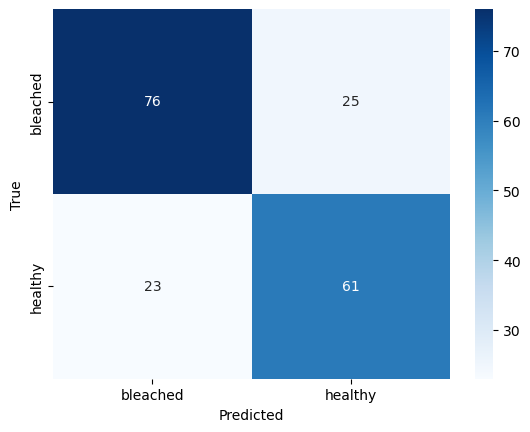

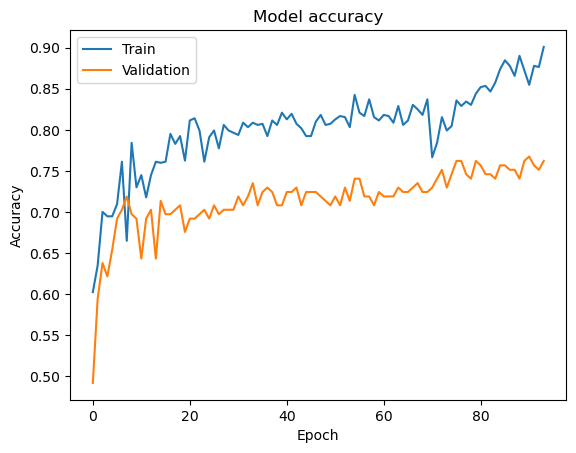

Image 1: Predicted Label = 1, Confidence Level = 0.70
Image 2: Predicted Label = 1, Confidence Level = 0.55
Image 3: Predicted Label = 0, Confidence Level = 0.28
Image 4: Predicted Label = 1, Confidence Level = 0.79
Image 5: Predicted Label = 1, Confidence Level = 0.95
Image 6: Predicted Label = 0, Confidence Level = 0.14
Image 7: Predicted Label = 1, Confidence Level = 0.79
Image 8: Predicted Label = 1, Confidence Level = 0.98
Image 9: Predicted Label = 1, Confidence Level = 0.54
Image 10: Predicted Label = 0, Confidence Level = 0.05


In [4]:
# Install dependencies
!pip install numpy pillow scikit-learn seaborn tensorflow

# Imports
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Dataset Overview
bleached_path = "./data/bleached_corals"
healthy_path = "./data/healthy_corals"

def get_image_paths(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Get all image paths
bleached_image_paths = get_image_paths(bleached_path)
print(f"Bleached Corals - Total Images: {len(bleached_image_paths)}")
healthy_image_paths = get_image_paths(healthy_path)
print(f"Healthy Corals - Total Images: {len(healthy_image_paths)}")

# Prepare dataset
image_paths = bleached_image_paths + healthy_image_paths
labels = ['bleached'] * len(bleached_image_paths) + ['healthy'] * len(healthy_image_paths)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42)

# Image Data Generator with Augmentation
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((299, 299))
    img = np.array(img)
    if img.shape[2] == 4:  # Remove alpha channel if present
        img = img[:, :, :3]
    return img

train_images = np.array([preprocess_image(path) for path in train_paths])
test_images = np.array([preprocess_image(path) for path in test_paths])

train_images = train_images / 255.0
test_images = test_images / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load GoogleNet (InceptionV3) model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=80,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=80,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Make predictions
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int)

# Add confidence levels
confidence_levels = predictions.flatten()

# Classification report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Display confidence levels for a few predictions
for i in range(10):
    print(f"Image {i+1}: Predicted Label = {predicted_labels[i][0]}, Confidence Level = {confidence_levels[i]:.2f}")

In [ ]:
the above is done for incorporating confidence levels